## Capstone Project: FY 2017 USDA Assistance
**Author: James McStay**

**October 2017**

This report aims to gain some insights on how U.S. Department of Agriculture (USDA) assistance - in the form of grants, loans, and other financial assistance - were broken down and distributed in fiscal year (FY) 2017 (October 2016 - September 2017) by the USDA agencies and staff offices that are responsible for these funds. 

The data was obtained from https://www.usaspending.gov, which is the publicly accessible, searchable website mandated by the Federal Funding Accountability and Transparency Act of 2006 to give the American public access to information on how their tax dollars are spent. The data contains information about the name of the entity receiving the award, the amount of the award, the recipient’s location, and the place of performance location, among others.

### Key Term:
***Federal assistance*** is any federal activity provided by the federal government that involves the transfer of money, property, services, or anything of value to accomplish a public purpose of support or stimulation that directly assists domestic entities or individuals in the areas of education, health, and public welfare, among others. The federal government provided over 2.13 trillion dollars in assistance in FY 2017.

### Key Questions:

**1)** Which USDA agency provided the most assistance? Are there outliers? What types of assistance and recipient were most funded? 

**2)** What was the funding distribution for programs that provided the most assistance?

**3)** What was the average and breakdown of the assistance for the non-outlier agencies?

**4)** Are there notable correlations among variables?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
import scipy as sp
import scipy.stats
from matplotlib.ticker import FuncFormatter
%matplotlib inline

In [2]:
# Open/read the csv file and return the number of rows and columns.
df = pd.read_csv('usda_assistance.csv')
df.shape

C:\Users\James\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7,15,16,27,31,33,56,58,60,62,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(431817, 67)

## Data Cleaning

In [3]:
# Show columns with sample data.
df.ix[3,:]

unique_transaction_id                      CF44FB27-E48E-43E7-BC04-CE787C8923D5
transaction_status                                                       active
fyq                                                                       20171
cfda_program_num                                                         10.703
sai_number                                                           SAI EXEMPT
account_title                                                               NaN
recipient_name                                           STATE FORESTER ARIZONA
recipient_city_code                                                         NaN
recipient_city_name                                                     PHOENIX
recipient_county_code                                                        13
recipient_county_name                                                  MARICOPA
recipient_zip                                                       8.50073e+08
recipient_type                          

In [4]:
# Set float format.
pd.options.display.float_format = '{:,.0f}'.format

# Convert cfda_program_num column to string.
df['cfda_program_num'] = df['cfda_program_num'].astype('str')

In [5]:
# Check for missing values in the applicable columns. If "false," rows will not be dropped when that column is used 
# for plotting or calculations.
print(df['unique_transaction_id'].isnull().values.any())
print(df['cfda_program_num'].isnull().values.any())
print(df['recipient_type'].isnull().values.any())
print(df['fed_funding_amount'].isnull().values.any())
print(df['assistance_type'].isnull().values.any())
print(df['agency_name'].isnull().values.any())
print(df['recipient_state_code'].isnull().values.any())

False
False
False
False
False
False
True


In [6]:
# Consolidate multiple occurences of each agency name.
df['agency_name'] = df['agency_name'].replace({'Agricultural Marketing Service (02)':'Agricultural Marketing Service', 
                                               'Agricultural Research Service (03)':'Agricultural Research Service', 
                                               'Animal & Plant Health Inspection Service (34)':'Animal and Plant Health Inspection Service',
                                               'Economic Research Service (18)':'Economic Research Service',
                                               'Farm Service Agency (FA)':'Farm Service Agency',
                                               'Food and Nutrition Service (30)':'Food and Nutrition Service',
                                               'Foreign Agricultural Service (10)':'Foreign Agricultural Service',
                                               'Forest Service (11)':'Forest Service',
                                               'National Agricultural Statistics Service (20)':'National Agricultural Statistics Service',
                                               'National Institute of Food and Agriculture (22)':'National Institute of Food and Agriculture',
                                               'Natural Resources Conservation Service (16)':'Natural Resources Conservation Service',
                                               'Risk Management Agency (08)':'Risk Management Agency',
                                               'Rural Business Cooperative Service (32)':'Rural Business Cooperative Service',
                                               'Rural Housing Service (07)':'Rural Housing Service',
                                               'Rural Utilities Service (15)':'Rural Utilities Service'})

## Question 1.1

### Which USDA agency provided the most assistance? Are there outliers?
The top two agencies, which were the outliers that exhibited extreme levels of funding and transactions, were the Food and Nutrition Service (FNS) and the Farm Service Agency (FSA). The bulk of program transactions - over 400k - were from the FSA, but the amount of assistance it provided was less than one-third of the FNS’s, which was over 35 billion dollars.

In [7]:
# Create a dataframe showing the total funding provided and number of program transactions by each agency.
df_agency = (df.groupby(['agency_name']).agg({'fed_funding_amount': 'sum', 'unique_transaction_id': 'count'}).sort_values(by='fed_funding_amount', ascending=False)).reset_index()
df_agency.rename(columns={'agency_name': 'USDA Agency', 'unique_transaction_id': 'Number of Transactions', 'fed_funding_amount': 'Federal Funding ($)'}, inplace=True)
df_agency['Funding %'] = df_agency['Federal Funding ($)'] * 100 / df_agency['Federal Funding ($)'].sum()
df_agency['Number of Transactions'] = df_agency['Number of Transactions'].astype('float64')
df_agency

,USDA Agency,Number of Transactions,Federal Funding ($),Funding %
0,Food and Nutrition Service,"9,573","35,657,701,924",75
1,Farm Service Agency,"406,661","10,941,738,057",23
2,Forest Service,"4,786","303,078,219",1
3,Rural Housing Service,"3,541","262,095,005",1
4,Foreign Agricultural Service,316,"78,324,354",0
5,National Institute of Food and Agriculture,309,"62,093,158",0
6,Natural Resources Conservation Service,"6,049","54,495,507",0
7,Food Safety and Inspection Service,52,"50,564,983",0
8,Rural Utilities Service,101,"26,031,399",0
9,Risk Management Agency,221,"23,657,669",0


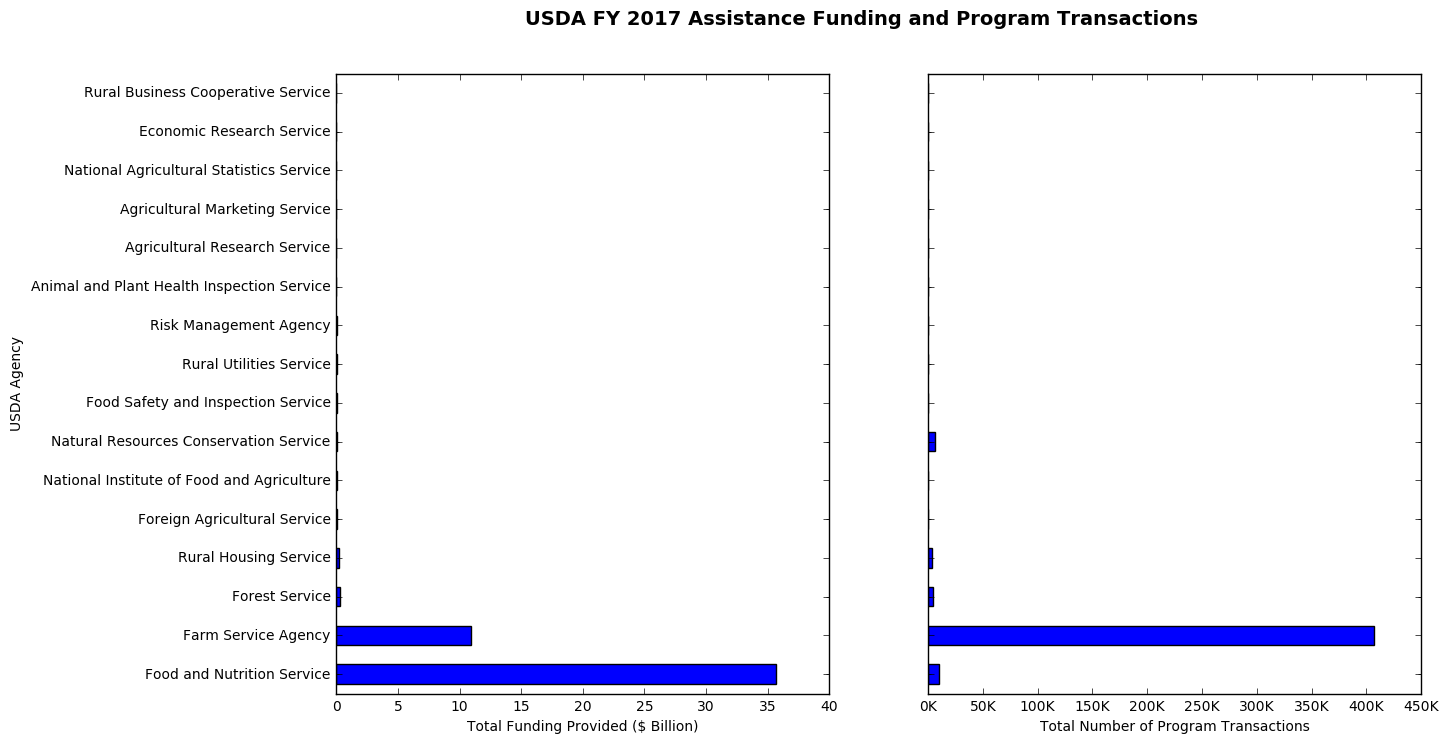

In [8]:
# Create bar plots showing the funding and total transactions by agency. 
fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2,sharey=True, figsize=(14, 8))

df_agency.plot(kind='barh', y='Federal Funding ($)', x='USDA Agency', ax=ax0)
def currency(x, pos):
    if x >= 10000000:
        return '{:1.0f}'.format(x*1e-9)
    return '{:1.0f}'.format(x*1e-3)
formatter = FuncFormatter(currency)
ax0.xaxis.set_major_formatter(formatter)
ax0.set_xlabel('Total Funding Provided ($ Billion)')
ax0.set_xlim([0, 40000000000])
ax0.legend().set_visible(False)

df_agency.plot(kind='barh', y='Number of Transactions', x='USDA Agency', ax=ax1)
def transactions(x, pos):
    if x >= 1000000:
        return '{:1.1f}'.format(x*1e-6)
    return '{:1.0f}K'.format(x*1e-3)
formatter = FuncFormatter(transactions)
ax1.xaxis.set_major_formatter(formatter)
ax1.set_xlabel('Total Number of Program Transactions')
ax1.legend().set_visible(False)

fig.suptitle('USDA FY 2017 Assistance Funding and Program Transactions', fontsize=14, fontweight='bold');

## Question 1.2 

### What types of assistance and recipient were most funded?
Over 90 percent of USDA's assistance went to state governments and individuals in the form of formula grants and direct payments. 

In [9]:
# Create a dataframe showing the total funding provided by assistance type.
df_assistance = (df.groupby(['assistance_type']).agg({'fed_funding_amount': 'sum', 'unique_transaction_id': 'count'}).sort_values(by='fed_funding_amount', ascending=False)).reset_index()
df_assistance.rename(columns={'assistance_type': 'Assistance Type', 'unique_transaction_id': 'Number of Transactions', 'fed_funding_amount': 'Federal Funding ($)'}, inplace=True)
df_assistance['Funding %'] = df_assistance['Federal Funding ($)'] * 100 / df_assistance['Federal Funding ($)'].sum()
df_assistance['Number of Transactions'] = df_agency['Number of Transactions'].astype('float64')
df_assistance

,Assistance Type,Number of Transactions,Federal Funding ($),Funding %
0,03: Formula grant,"9,573","33,049,430,607",70
1,10: Direct payment with unrestricted use (reti...,"406,661","6,778,007,028",14
2,"06: Direct payment for specified use, as a sub...","4,786","3,872,031,713",8
3,"11: Other reimbursable, contingent, intangible...","3,541","2,900,208,068",6
4,04: Project grant,316,"716,018,583",2
5,05: Cooperative agreement,309,"137,977,673",0
6,09: Insurance,"6,049","23,657,669",0
7,07: Direct loan,52,0,0
8,08: Guaranteed or insured loan,101,0,0


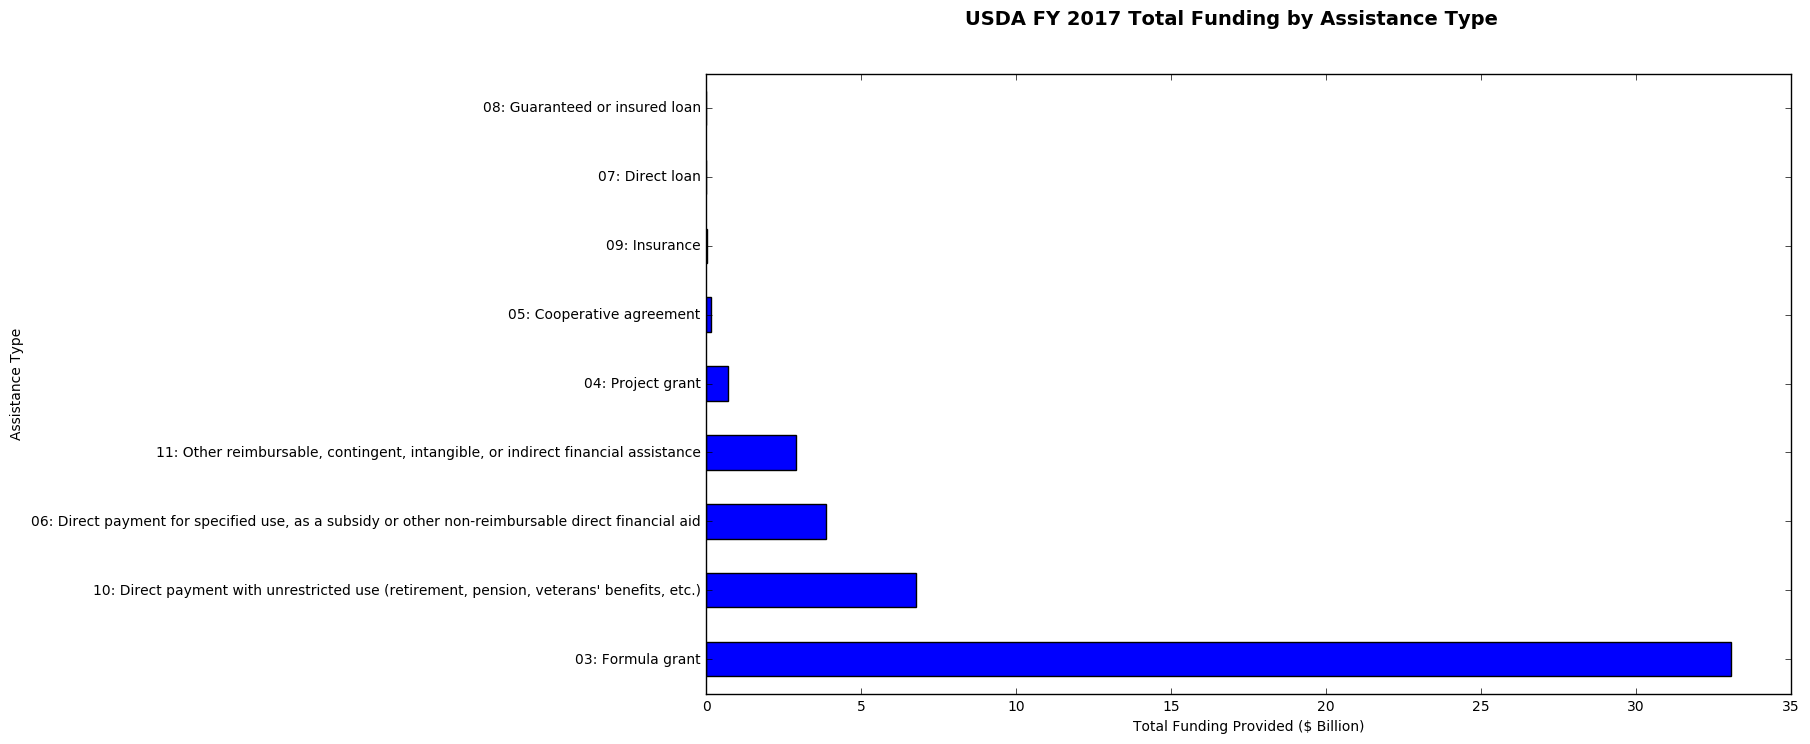

In [10]:
# Create a bar chart by assistance type.
fig, ax = plt.subplots(figsize=(14, 8))

df_assistance.plot(kind='barh', y='Federal Funding ($)', x='Assistance Type', ax=ax)
def currency(x, pos):
    if x >= 10000000:
        return '{:1.0f}'.format(x*1e-9)
    return '{:1.0f}'.format(x*1e-3)
formatter = FuncFormatter(currency)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Total Funding Provided ($ Billion)')
ax.set_xlim([0, 35000000000])
ax.legend().set_visible(False)

fig.suptitle('USDA FY 2017 Total Funding by Assistance Type', fontsize=14, fontweight='bold');

In [11]:
# Create a dataframe showing the total funding provided by recipient type.
df_recipient = (df.groupby(['recipient_type']).agg({'fed_funding_amount': 'sum', 'unique_transaction_id': 'count'}).sort_values(by='fed_funding_amount', ascending=False)).reset_index()
df_recipient.rename(columns={'recipient_type': 'Recipient Type', 'unique_transaction_id': 'Number of Transactions', 'fed_funding_amount': 'Federal Funding ($)'}, inplace=True)
df_recipient['Funding %'] = df_recipient['Federal Funding ($)'] * 100 / df_recipient['Federal Funding ($)'].sum()
df_recipient['Number of Transactions'] = df_recipient['Number of Transactions'].astype('float64')
df_recipient

,Recipient Type,Number of Transactions,Federal Funding ($),Funding %
0,00: State government,"9,544","35,665,374,078",75
1,21: Individual,"53,574","8,510,284,911",18
2,22: Profit organization,"315,209","2,442,961,202",5
3,23: Small business,"7,493","243,616,723",1
4,11: Indian tribe,"2,476","201,366,048",0
5,12: Other nonprofit,"3,909","123,729,130",0
6,25: All other,"35,873","121,783,097",0
7,06: State controlled institution of higher edu...,"2,636","108,191,727",0
8,02: City or township government,295,"31,865,220",0
9,01: County government,537,"13,934,247",0


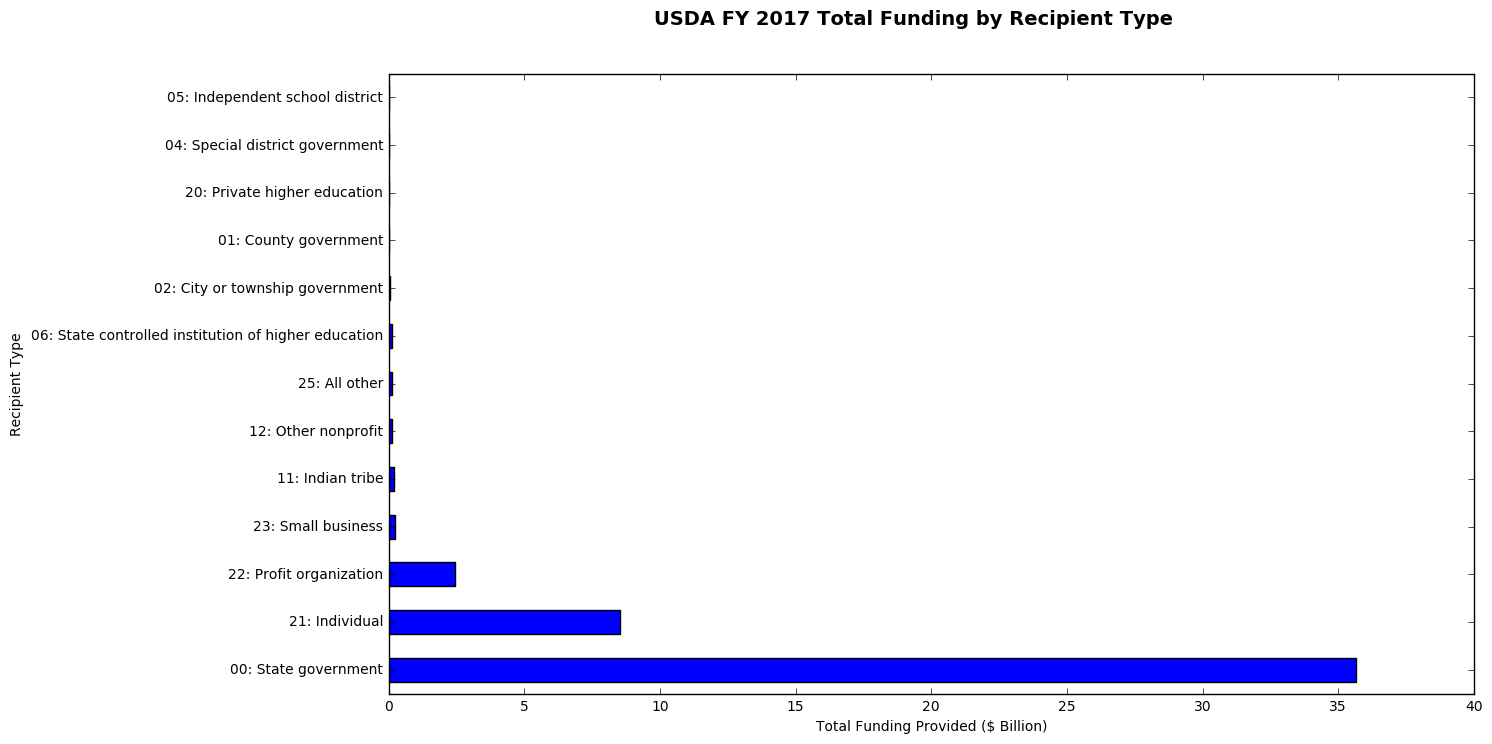

In [12]:
# Create a bar chart by recipient type.
fig, ax = plt.subplots(figsize=(14, 8))

df_recipient.plot(kind='barh', y='Federal Funding ($)', x='Recipient Type', ax=ax)
def currency(x, pos):
    if x >= 10000000:
        return '{:1.0f}'.format(x*1e-9)
    return '{:1.0f}'.format(x*1e-3)
formatter = FuncFormatter(currency)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Total Funding Provided ($ Billion)')
ax.set_xlim([0, 40000000000])
ax.legend().set_visible(False)

fig.suptitle('USDA FY 2017 Total Funding by Recipient Type', fontsize=14, fontweight='bold');

## Question 2  

## What was the payment distribution for the programs that provided the most funding?
Three-fourths of FSA’s transactions were from two programs - 10.112 and 10.113 - which involve price loss and agricultural risk coverage. Price loss coverage provides payments to farmers when prices for certain commodities, such as corn and wheat, fall below a fixed reference price set in statute. Agricultural risk coverage payments, on the other hand, are provided when crop revenue falls below 86 percent of historical revenue. The high volume of payments (mostly to landowners and producers in rural communities) is somewhat expected given the economic and environmental conditions in the past year brought about by natural disasters such drought, wildfires, and deadly hurricanes, among others, which adversely impacted crop production.

Over half of FNS's 36 billion dollars in assistance, on the other hand, came from a single source – The National School Lunch Program (10.555). This program provides low-cost or free lunches to more than 30 million children in approximately 95 percent of schools across the country on an average day. A distant second but still notable at over 6.7 billion dollars involves the Special Supplemental Nutrition Program for Women, Infants, and Children (10.557), which provides healthcare and nutrition assistance to low-income pregnant women, breastfeeding women, and children under the age of five. Both 10.555 and 10.557 are awarded as formula grants to states, which match these assistance and recipient types’ share of funding as shown in their corresponding plots.

The boxplot shows FSA's payments are clustered within a tight range compared to FNS's. As an example, FSA's 10.112 and 10.113 are within 20 million dollars, while FNS's 10.555 and 10.557 have a much wider range, with 10.555 having five payments over the 600 million dollar mark, two of which were over 700 million. This distribution is in line with the type of recipients these agencies and programs serve.

In [13]:
# Create a dataframe consisting only of FNS and FSA transactions.
df_fsa_fns = df[(df.agency_name == 'Farm Service Agency') | (df.agency_name == 'Food and Nutrition Service')]
df_fsa_fns_programs = df_fsa_fns.groupby(['cfda_program_num', 'agency_name']).agg({'fed_funding_amount': 'sum', 'unique_transaction_id': 'count'}).sort_values(by='fed_funding_amount', ascending=False).reset_index()
df_fsa_fns_programs.rename(columns={'agency_name': 'USDA Agency', 'cfda_program_num': 'Program Number', 'fed_funding_amount': 'Federal Funding ($)', 'unique_transaction_id': 'Number of Transactions'}, inplace=True)
df_fsa_fns_programs['Number of Transactions'] = df_fsa_fns_programs['Number of Transactions'].astype('float64')
df_fsa_fns_programs

,Program Number,USDA Agency,Number of Transactions,Federal Funding ($)
0,10.555,Food and Nutrition Service,982,"20,113,954,754"
1,10.557,Food and Nutrition Service,"1,575","6,703,517,570"
2,10.113,Farm Service Agency,"203,015","5,114,873,467"
3,10.561,Food and Nutrition Service,"1,943","4,948,044,230"
4,10.051,Farm Service Agency,"18,052","2,736,318,511"
5,10.566,Food and Nutrition Service,27,"1,945,815,509"
6,10.112,Farm Service Agency,"95,910","1,536,036,451"
7,10.069,Farm Service Agency,"77,727","1,444,894,422"
8,10.558,Food and Nutrition Service,758,"690,785,395"
9,10.56,Food and Nutrition Service,552,"337,798,461"


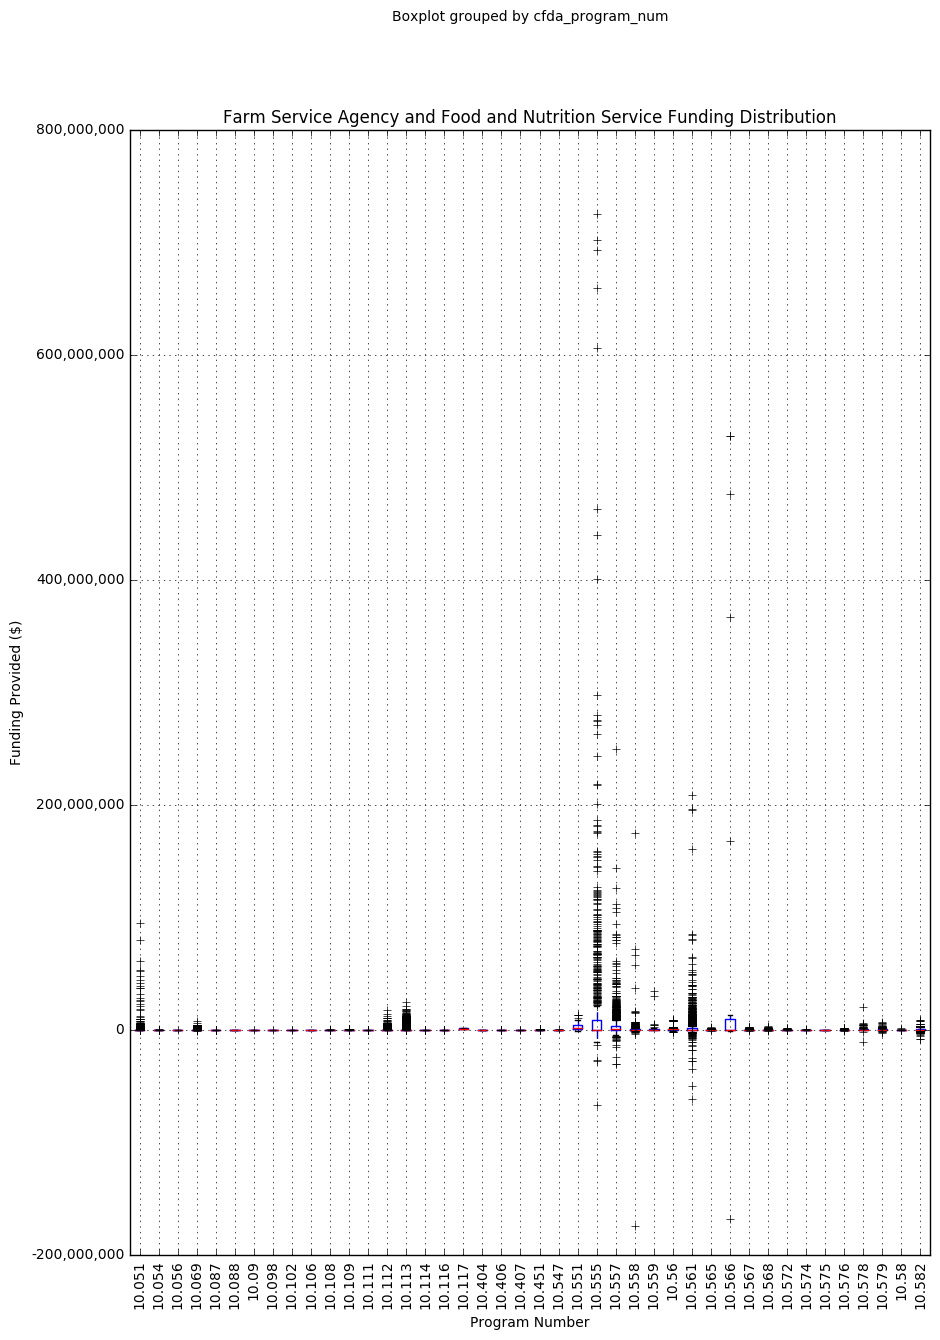

In [14]:
# Create a boxplot of FNS and FSA transactions.
df_fsa_fns.boxplot(column = 'fed_funding_amount', by = 'cfda_program_num', figsize=(10, 15))
ax = plt.gca()
ax.set_yticklabels(ax.get_yticks())
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.xlabel('Program Number')
plt.ylabel('Funding Provided ($)')
plt.title('Farm Service Agency and Food and Nutrition Service Funding Distribution')
plt.xticks(rotation=90)
plt.show()

## Question 3

## What was the average and breakdown of the assistance for the non-outlier agencies?
Taking out the outliers - the top four and bottom four agencies that exhibited "extreme" levels of funding (refer to dataframe in 1.1) - what does the average USDA assistance look like? The average total assistance for the non-outlier agencies was about 39 million dollars (indicated by dashed vertical line). The plots show a mixture of assistance and recipient types that correspond to the agencies’ purpose and mission. For example, the Risk Management Agency provided insurance to profit organizations, which is in line with its mission to promote and regulate sound risk management solutions to agricultural producers through its partnerships with private insurance companies that are responsible for various insurance policies. 

All the non-outlier agencies' error bars, except for the National Institute of Food and Agriculture (NIFA), exhibit a wide spread, which indicate the assistance provided by each agency varied greatly from its average assistance - as opposed to NIFA's, which has a tight cluster around its mean. Consequently, these agencies’ average assistance do not necessarily represent their assistance data accurately. For example, in the case of the Animal and Plant Health Inspection Service, it would be inaccurate to state its assistance, on average, was 300,000 dollars because of the wide variation in assistance, from a low of about 20,000 dollars to a high of close to 600,000 dollars.

Lastly, the only comparison that can be made regarding statistical significance among the agencies include the Agricultural Research Service ARS vs. the Rural Utilities Service RUS. Since they have almost the same number of transactions (a little over 100), and their error bars do not overlap, it can be concluded that the difference between their average assistance is statistically significant with a P value less than 0.05, i.e., the difference is caused by something other than random chance.

In [15]:
# Create a dataframe showing the breakdown by agency, assistance and recipient types.
df2 = df.groupby(['agency_name', 'assistance_type', 'recipient_type'])['fed_funding_amount'].sum().unstack('assistance_type').fillna(0)
df2['Total'] = df2.sum(axis=1)
df2

assistance_type                                                                                03: Formula grant  \
agency_name                                recipient_type                                                          
Agricultural Marketing Service             01: County government                                               0   
                                           04: Special district government                                     0   
                                           22: Profit organization                                             0   
Agricultural Research Service              00: State government                                                0   
                                           06: State controlled institution of higher educ...                  0   
                                           12: Other nonprofit                                                 0   
                                           20: Private higher education                                        0   
                                           25: All other                                                       0   
Animal and Plant Health Inspection Service 00: State government                                                0   
                                           06: State controlled institution of higher educ...                  0   
                                           12: Other nonprofit                                                 0   
                                           22: Profit organization                                             0   
                                           25: All other                                                       0   
Economic Research Service                  00: State government                                                0   
                                           06: State controlled institution of higher educ...                  0   
                                           12: Other nonprofit                                                 0   
                                           25: All other                                                       0   
Farm Service Agency                        00: State government                                                0   
                                           06: State controlled institution of higher educ...                  0   
                                           11: Indian tribe                                                    0   
                                           12: Other nonprofit                                                 0   
                                           21: Individual                                                      0   
                                           22: Profit organization                                             0   
                                           23: Small business                                                  0   
                                           25: All other                                                       0   
Food Safety and Inspection Service         00: State government                                                0   
Food and Nutrition Service                 00: State government                                   32,973,247,603   
                                           01: County government                                               0   
                                           02: City or township government                                     0   
                                           05: Independent school district                                     0   
...                                                                                                          ...   
National Institute of Food and Agriculture 06: State controlled institution of higher educ...           -581,882   
                                           12: Other non

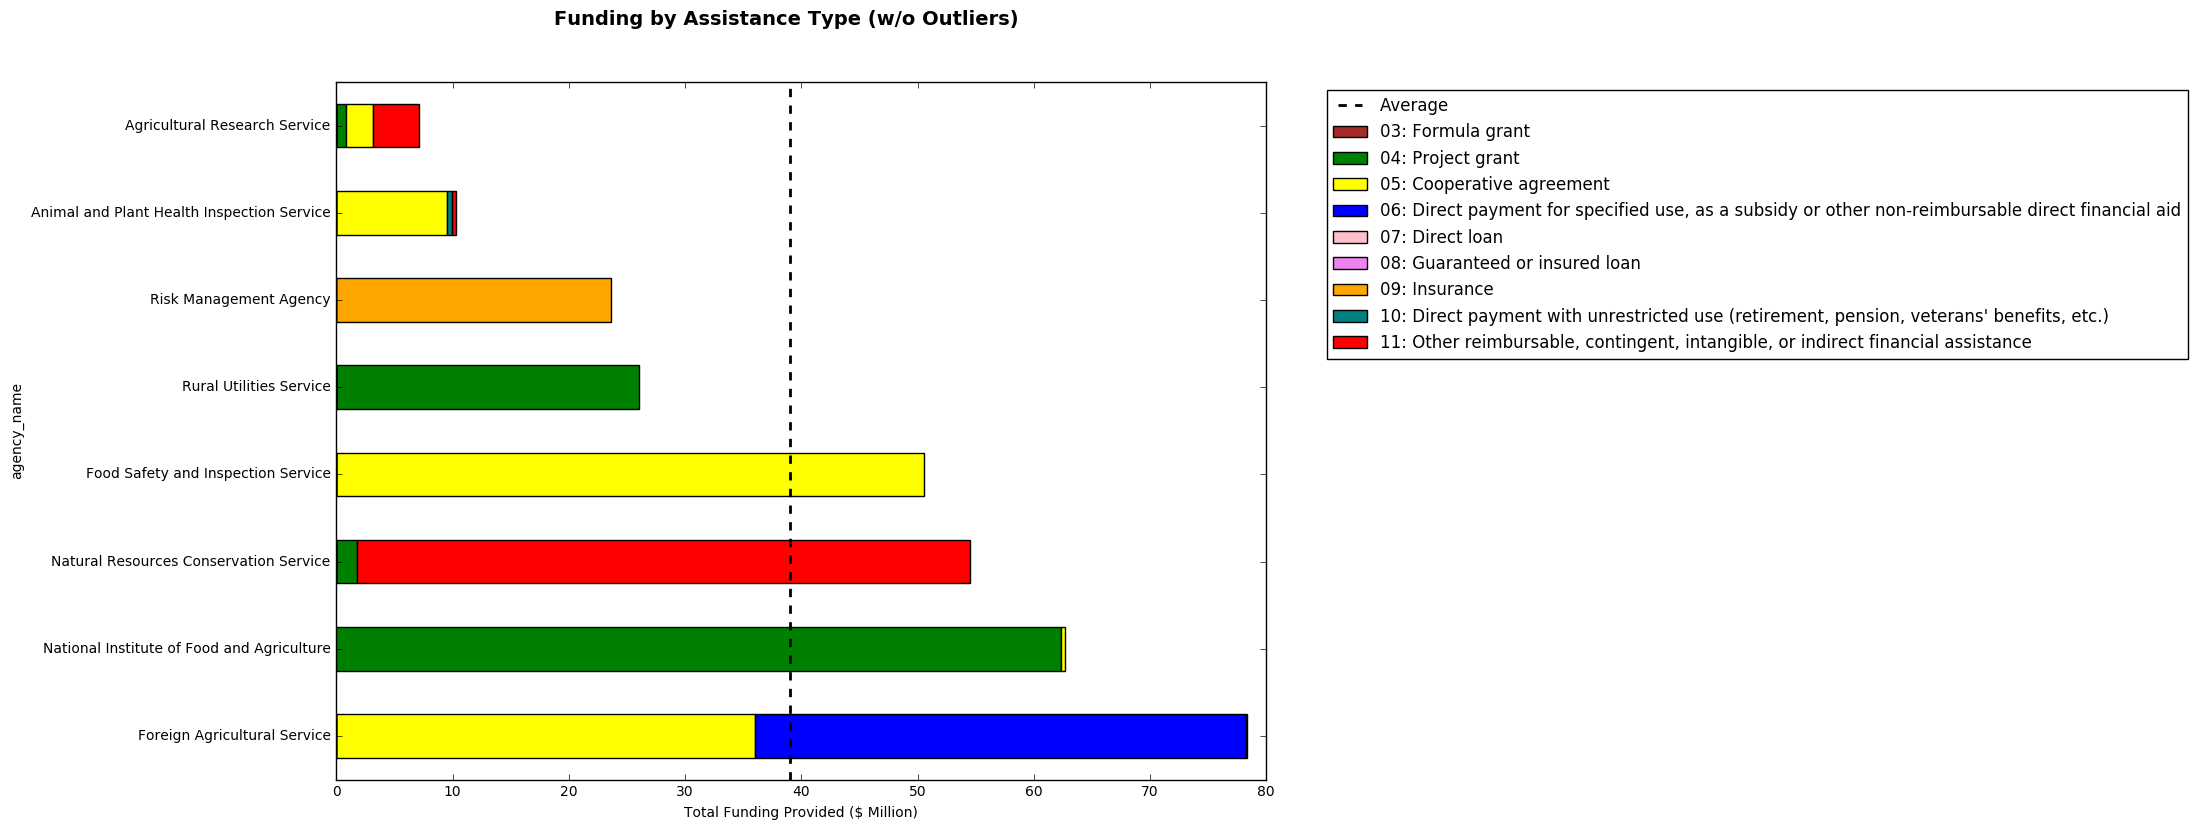

In [16]:
# Create a stacked bar graph showing agency and assistance type breakdown for the non-outlier agencies.
df3 = df.groupby(['agency_name', 'assistance_type'])['fed_funding_amount'].sum().unstack('assistance_type').fillna(0)
df3['Total'] = df3.sum(axis=1)
df_assistance_no_outliers = df3.sort_values(by='Total', ascending = False)[4:12]

fig, ax = plt.subplots(figsize=(12, 9))
colors = ['brown', 'green', 'yellow', 'blue', 'pink', 'violet', 'orange', 'teal', 'red']
df_assistance_no_outliers.drop('Total', axis=1).plot(kind='barh', stacked=True, color=colors, ax=ax)
avg = df_assistance_no_outliers['Total'].mean()
ax.axvline(x=avg, color='black', label='Average', linestyle='--', linewidth=2)
def currency(x, pos):
    if x >= 10000000:
        return '{:1.0f}'.format(x*1e-6)
    return '{:1.0f}'.format(x*1e-4)
formatter = FuncFormatter(currency)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Total Funding Provided ($ Million)')
ax.set_xlim([0, 80000000])
ax.legend(bbox_to_anchor=(2,1), loc='best')
fig.suptitle('Funding by Assistance Type (w/o Outliers)', fontsize=14, fontweight='bold');

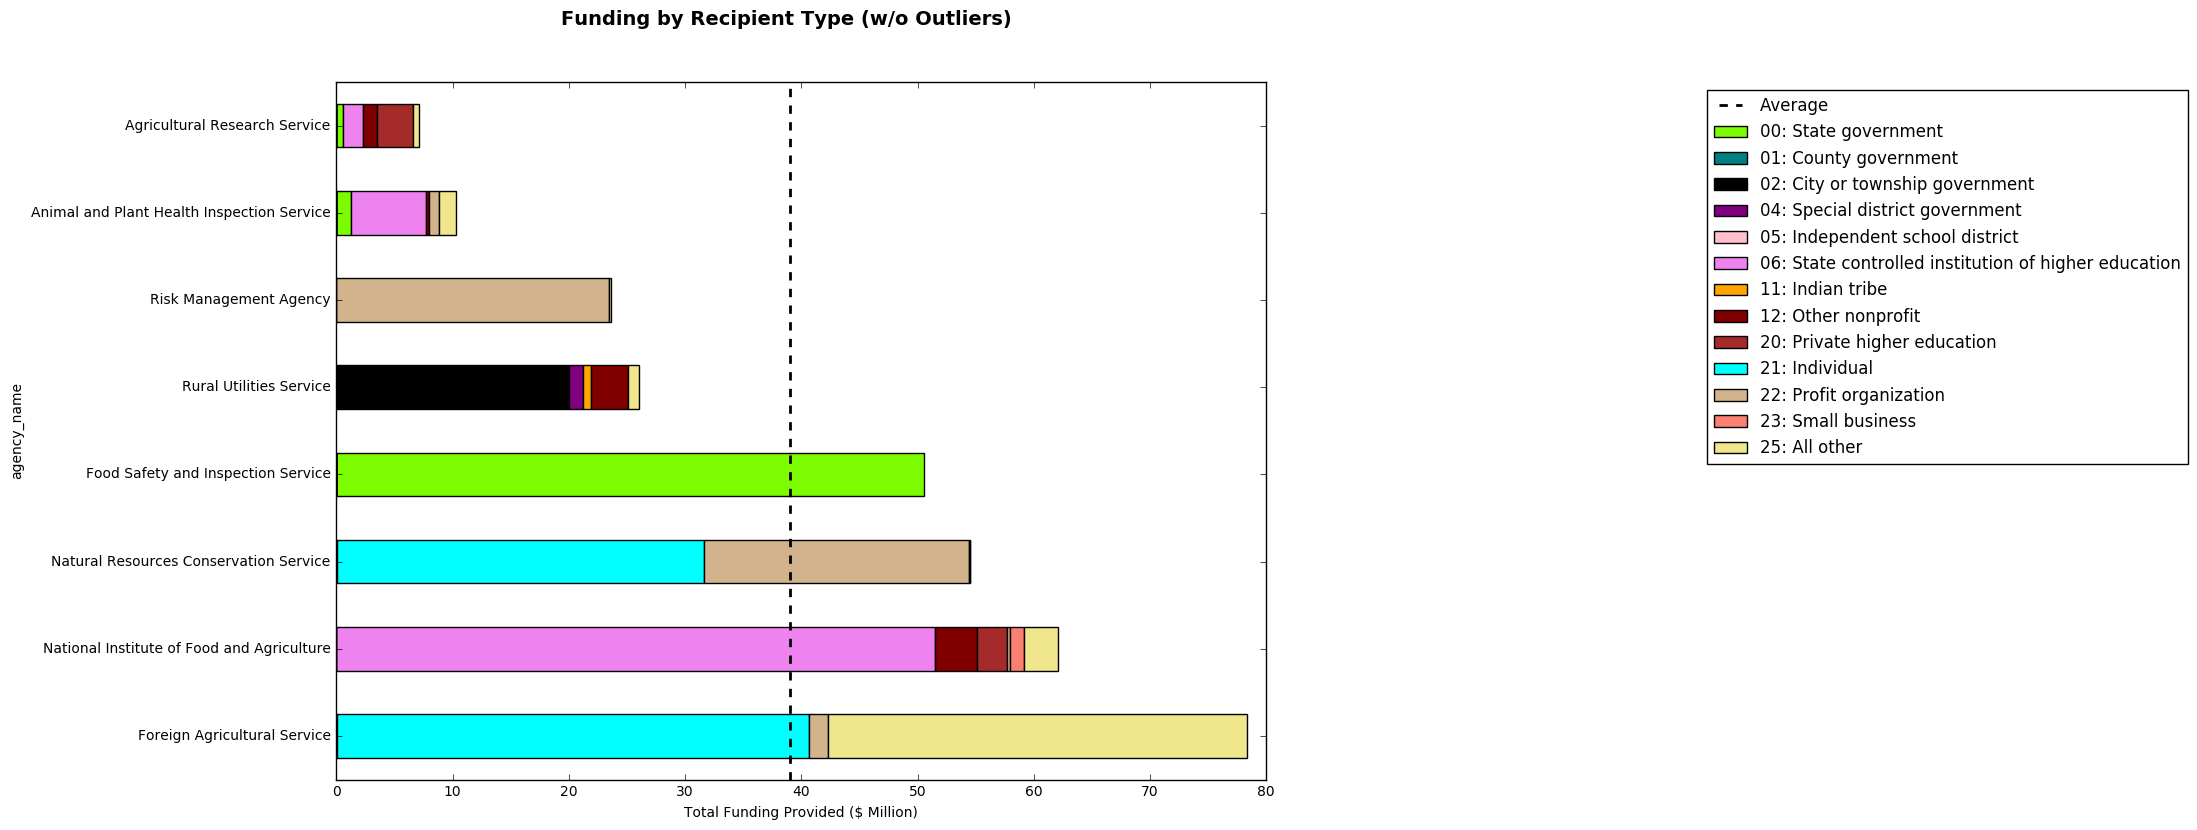

In [17]:
# Create a stacked bar graph showing agency and recipient type breakdown for the non-outlier agencies.
df4 = df.groupby(['agency_name', 'recipient_type'])['fed_funding_amount'].sum().unstack('recipient_type').fillna(0)
df4['Total'] = df4.sum(axis=1)
df_recipient_no_outliers = df4.sort_values(by='Total', ascending = False)[4:12]

fig, ax = plt.subplots(figsize=(12, 9))
colors = ['lawngreen', 'teal', 'black', 'purple', 'pink', 'violet', 'orange', 'maroon', 'brown', 'aqua', 'tan', 'salmon', 'khaki']
df_recipient_no_outliers.drop('Total', axis=1).plot(kind='barh', stacked=True, color=colors, ax=ax)
avg = df_recipient_no_outliers['Total'].mean()
ax.axvline(x=avg, color='black', label='Average', linestyle='--', linewidth=2)
def currency(x, pos):
    if x >= 10000000:
        return '{:1.0f}'.format(x*1e-6)
    return '{:1.0f}'.format(x*1e-4)
formatter = FuncFormatter(currency)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Total Funding Provided ($ Million)')
ax.set_xlim([0, 80000000])
ax.legend(bbox_to_anchor=(2,1), loc='best')
fig.suptitle('Funding by Recipient Type (w/o Outliers)', fontsize=14, fontweight='bold');

In [18]:
# Calculate for the non-outliers' means.
ars_m = df[(df['agency_name'] == 'Agricultural Research Service')]['fed_funding_amount'].mean()
aphis_m = df[(df['agency_name'] == 'Animal and Plant Health Inspection Service')]['fed_funding_amount'].mean()
rma_m = df[(df['agency_name'] == 'Risk Management Agency')]['fed_funding_amount'].mean()
rus_m = df[(df['agency_name'] == 'Rural Utilities Service')]['fed_funding_amount'].mean()
fsis_m = df[(df['agency_name'] == 'Food Safety and Inspection Service')]['fed_funding_amount'].mean()
nrcs_m = df[(df['agency_name'] == 'Natural Resources Conservation Service')]['fed_funding_amount'].mean()
nifa_m = df[(df['agency_name'] == 'National Institute of Food and Agriculture')]['fed_funding_amount'].mean()
fas_m = df[(df['agency_name'] == 'Foreign Agricultural Service')]['fed_funding_amount'].mean()

# Calculate for the non-outliers' confidence intervals (95%).
def confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m-h, m+h
    
ars_ci = confidence_interval(df[(df['agency_name'] == 'Agricultural Research Service')]['fed_funding_amount'], confidence=0.95)
aphis_ci = confidence_interval(df[(df['agency_name'] == 'Animal and Plant Health Inspection Service')]['fed_funding_amount'], confidence=0.95)
rma_ci = confidence_interval(df[(df['agency_name'] == 'Risk Management Agency')]['fed_funding_amount'], confidence=0.95)
rus_ci = confidence_interval(df[(df['agency_name'] == 'Rural Utilities Service')]['fed_funding_amount'], confidence=0.95)
fsis_ci = confidence_interval(df[(df['agency_name'] == 'Food Safety and Inspection Service')]['fed_funding_amount'], confidence=0.95)
nrcs_ci = confidence_interval(df[(df['agency_name'] == 'Natural Resources Conservation Service')]['fed_funding_amount'], confidence=0.95)
nifa_ci = confidence_interval(df[(df['agency_name'] == 'National Institute of Food and Agriculture')]['fed_funding_amount'], confidence=0.95)
fas_ci = confidence_interval(df[(df['agency_name'] == 'Foreign Agricultural Service')]['fed_funding_amount'], confidence=0.95)

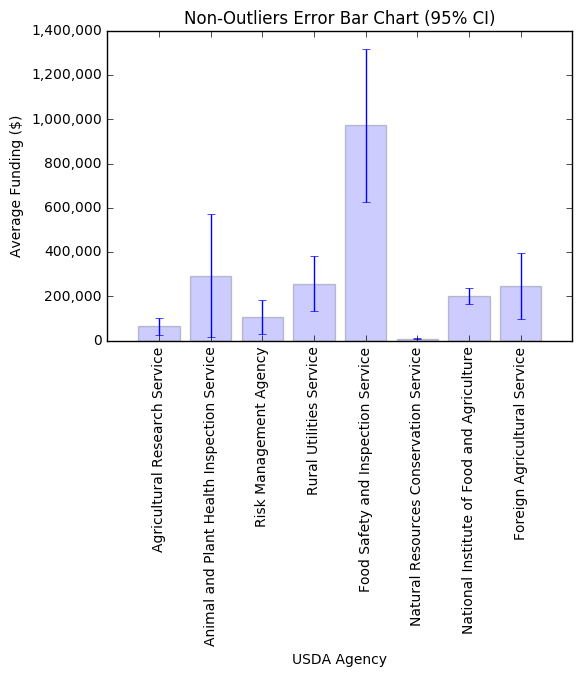

In [19]:
# Plot the error bars.
agencies = ['Agricultural Research Service','Animal and Plant Health Inspection Service','Risk Management Agency','Rural Utilities Service', 'Food Safety and Inspection Service', 'Natural Resources Conservation Service', 'National Institute of Food and Agriculture', 'Foreign Agricultural Service']
means = [ars_m, aphis_m, rma_m, rus_m, fsis_m, nrcs_m, nifa_m, fas_m]
conf_int = [ars_ci, aphis_ci, rma_ci, rus_ci, fsis_ci, nrcs_ci, nifa_ci, fas_ci]

y_r = [means[i] - conf_int[i][1] for i in range(len(conf_int))]
plt.bar(range(len(means)), means, yerr=y_r, alpha=0.2, align='center')
plt.xticks(range(len(means)), agencies, rotation=90)
plt.xlabel('USDA Agency')
plt.ylabel('Average Funding ($)')
ax = plt.gca()
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.title('Non-Outliers Error Bar Chart (95% CI)')
plt.show()

## Question 4 

## Are there notable correlations among the variables?
Multiple correlations can be shown for the different variables, but for purposes of illustration, only the ones showing a positive correlation with the federal funding amount are shown. This implies that these variables move in tandem with the federal funding amount: as federal funding increases, a corresponding increase in these variables can be observed, and vice versa. The closer the correlation coefficient is to 1.0, the stronger the relationship between the variable and the federal funding amount. The Food and Nutrition Service, 10.555, 10.557, 10.566, formula grants, and state governments have coefficients closest to 1.0; as such, these variables should expect more pronounced upticks in activity when federal funding goes up.

In [20]:
# Create a dataframe with the desired columns/variables.
df5 = df.groupby(['agency_name', 'cfda_program_num', 'assistance_type', 'recipient_type', 'recipient_state_code']).agg({'fed_funding_amount': 'sum'}).reset_index()

# Set dummy variables for the categorical columns to allow for correlation calculation.
df6 = pd.get_dummies(data=df5, columns = ['agency_name', 'cfda_program_num', 'assistance_type', 'recipient_type', 'recipient_state_code'])

# Create the correlation table.
df7 = df6.corr()

# Set the float format.
pd.options.display.float_format = '{:,.4f}'.format

# Show which variables have a positive correlation with the federal funding amount.
print(df7['fed_funding_amount'][(df7['fed_funding_amount']>0) & (df7['fed_funding_amount']!=1)])

agency_name_Food and Nutrition Service   0.1869
cfda_program_num_10.051                  0.0008
cfda_program_num_10.113                  0.0265
cfda_program_num_10.551                  0.0030
cfda_program_num_10.555                  0.4651
cfda_program_num_10.557                  0.1335
cfda_program_num_10.558                  0.0034
cfda_program_num_10.559                  0.0005
cfda_program_num_10.561                  0.1104
cfda_program_num_10.566                  0.3553
cfda_program_num_10.608                  0.0007
assistance_type_03: Formula grant        0.2565
recipient_type_00: State government      0.1543
recipient_state_code_CA                  0.0432
recipient_state_code_FL                  0.0188
recipient_state_code_GA                  0.0168
recipient_state_code_IA                  0.0068
recipient_state_code_IL                  0.0225
recipient_state_code_IN                  0.0093
recipient_state_code_LA                  0.0042
recipient_state_code_MI                 

## Further Research

This report provided a high-level overview of USDA’s FY 2017 assistance. Some points to consider for further research include:

**1)** Trends across multiple FYs that would provide information on agencies’ activities across different timeframes.  

**2)** Correlation and clustering techniques that would provide clearer insights on how variables could actually be related to each other. Since the data is mostly categorical, the chi-square test would perhaps be more appropriate as opposed to the Pearson correlation coefficients that were derived above.  

**3)** Conduct anomaly detection to determine if any of the data is out of place; for example, did agencies provide funding to certain recipients more than they should have?  

**4)** An area map to show assistance distribution across the country.  